In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
import anndata as ad
import scipy.stats as stats
import tacco as tc
import os

/home/lagwankar/.local/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:21: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [51]:
# Sample XETG00102__0015463_B015_H2

In [52]:
# read in matrix file
adata = sc.read_10x_h5(
    filename="/storage1/fs1/sanjayjain/Active/Xenium/Data/IntegratedST_Xenium_Data/B015_H2/cell_feature_matrix.h5"
)

In [53]:
# read in cells.csv
df = pd.read_csv(
    "/storage1/fs1/sanjayjain/Active/Xenium/Data/IntegratedST_Xenium_Data/B015_H2/cells.csv"
)

In [54]:
# update obs metadata with info from df
df.set_index(adata.obs_names, inplace = True)
adata.obs = df.copy()

In [55]:
adata

AnnData object with n_obs × n_vars = 240201 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'

In [56]:
# storing x and y spatial coordinates of cells in anndata object 
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [57]:
# calculate quality control metrics and calculate cumulative sum for the top 10, 20, 50, and 150 genes
# add them to adata.obs and adata.var
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

## Pre-Filtering Negative Probe Count and Negative Decoding Count

In [58]:
# calculate percentage of control probes and control codewords from adata.obs
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

print(f"Negative DNA Probe Count %: {cprobes}")
print(f"Negative Decoding Count %: {cwords}")

Negative DNA Probe Count %: 0.004802743441746306
Negative Decoding Count %: 0.003810213224163832


## Pre QC Metrics

In [59]:
total_cell_area_um2 = 9242417.5
time_interval = 100000

In [60]:
# transcripts per 100 µm² (use cell area)
cells_per_square_micrometer = adata.obs['transcript_counts'].sum() / (total_cell_area_um2) * 100
print(f"Total number of transcripts per 100 um squared: {cells_per_square_micrometer:.2f}")

# total cells
print(f"Total number of cells: {adata.shape[0]}")

# total high-quality decoded transcripts
total_high_quality_transcripts = adata.obs['transcript_counts'].sum()
print(f"Total Transcripts: {total_high_quality_transcripts}")

# median number of genes per cell
median_genes_per_cell = adata.obs['n_genes_by_counts'].median()
print(f"Median number of genes per cell: {median_genes_per_cell:.2f}")

# total genes per cell
total_gene_expressions = adata.obs['n_genes_by_counts'].sum()
number_of_cells = adata.shape[0]
average_genes_per_cell = total_gene_expressions / number_of_cells
print(f"Total number of genes per cell (avg): {average_genes_per_cell:.2f}")

# median transcripts per cell
non_zero_transcripts = adata.obs[adata.obs['transcript_counts'] > 0]
median_transcripts = non_zero_transcripts['transcript_counts'].median()
print(f"Median transcripts per cell: {median_transcripts}")

# percentage of cells without transcripts
cells_without_transcripts = (adata.obs['n_genes_by_counts'] == 0).sum()
print(f"Cells without transcripts: {cells_without_transcripts}")
total_cells = adata.shape[0]
percentage_without_transcripts = (cells_without_transcripts / total_cells) * 100
print(f"Percentage of cells without transcripts: {percentage_without_transcripts:.2f}%")

Total number of transcripts per 100 um squared: 196.22
Total number of cells: 240201
Total Transcripts: 18135471
Median number of genes per cell: 23.00
Total number of genes per cell (avg): 23.96
Median transcripts per cell: 56.0
Cells without transcripts: 685
Percentage of cells without transcripts: 0.29%


## Filtering and Processing

In [61]:
# remove cells with fewer than 5 total gene counts
sc.pp.filter_cells(adata, min_counts=5)

# remove genes that are not expressed in any cell
sc.pp.filter_genes(adata, min_cells=1)

In [62]:
# normalize counts per cell, logarithmize, PCA, compute neighborhood graph
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=200)

## Initial UMAP

In [63]:
# embed the neighborhood graph of data and cluster cells into subgroups
sc.tl.umap(adata)
sc.tl.leiden(adata)

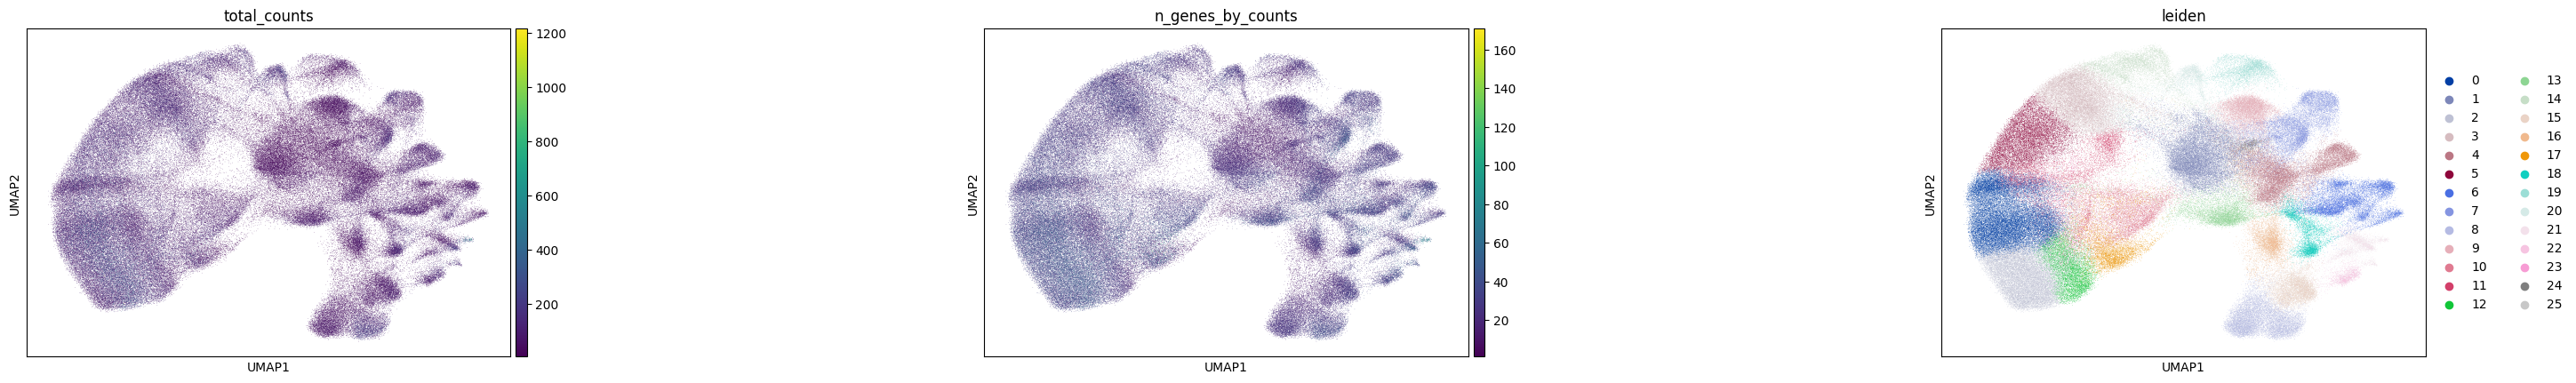

In [64]:
# umap
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.8,
)

/usr/local/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/usr/local/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


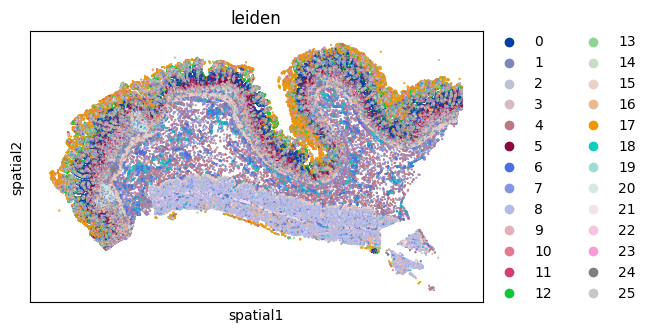

In [65]:
# spatial
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        "leiden",
    ],
    wspace=0.4,
)

## False Discovery Rate

In [66]:
# total transcript calls (TTC)
total_transcript_calls = adata.obs['total_counts'].sum()
print(f"Total Transcript Calls: {total_transcript_calls}")

# negative control calls (NCC)
negative_control_calls = adata.obs['control_probe_counts'].sum()
print(f"Total Negative Control Calls: {negative_control_calls}")

# number of negative control probes (NCPs)
number_of_negative_control_probes = 20 ## VERIFY!

# number of real gene probes (RGPs)
number_of_panel_genes = 300 ## VERIFY!

# calculate FDR (10x)
fdr_step1 = (negative_control_calls / total_transcript_calls) * (number_of_panel_genes / number_of_negative_control_probes)
FDR_1 = fdr_step1 * 100
print(f"False Discovery Rate Xenium (FDR%): {FDR_1}%")

# calculate FDR (squidpy)
FDR_2 = (negative_control_calls / total_transcript_calls) * 100
print(f"False Discovery Rate Squidpy (FDR%): {FDR_2}%")

Total Transcript Calls: 18119186.0
Total Negative Control Calls: 854
False Discovery Rate Xenium (FDR%): 0.07069854021036044%
False Discovery Rate Squidpy (FDR%): 0.004713236014024029%


## Post-Filtering Negative Probe Count and Negative Decoding Count

In [67]:
# calculate percentage of control probes and control codewords from adata.obs
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

print(f"Negative DNA Probe Count %: {cprobes}")
print(f"Negative Decoding Count %: {cwords}")

Negative DNA Probe Count %: 0.004713236014024029
Negative Decoding Count %: 0.003758446985421972


## Post-QC Metrics

In [68]:
# total cells per mm2
total_cell_area_mm = total_cell_area_um2 / 1000000
cells_per_square_millimeter = len(adata.obs) / (total_cell_area_mm)
print(f"Total number of cells per square millimeter: {cells_per_square_millimeter:.2f}")

# total transcripts per cell
number_of_cells = adata.shape[0]
total_high_quality_transcripts = adata.obs['transcript_counts'].sum() / number_of_cells
print(f"Total Transcripts per cell post-QC: {total_high_quality_transcripts}")

# total cells
print(f"Total number of cells post-QC: {adata.shape[0]}")

# total high-quality decoded transcripts
total_high_quality_transcripts = adata.obs['transcript_counts'].sum()
print(f"Total number of transcripts post-QC: {total_high_quality_transcripts}")

# average area per cell
average_cell_area = adata.obs['cell_area'].mean()
print(f"Average cell area post-QC: {average_cell_area:.2f}")

# percent of cells without transcripts
cells_without_transcripts = (adata.obs['n_genes_by_counts'] == 0).sum()
total_cells = adata.shape[0]
percentage_without_transcripts = (cells_without_transcripts / total_cells) * 100
print(f"Percentage of cells without transcripts post-QC: {percentage_without_transcripts:.2f}%")

# median number of genes per cell
median_genes_per_cell = adata.obs['n_genes_by_counts'].median()
print(f"Median number of genes per cell post-QC: {median_genes_per_cell:.2f}")

# total genes per cell
total_gene_expressions = adata.obs['n_genes_by_counts'].sum()
average_genes_per_cell = total_gene_expressions / number_of_cells
print(f"Average number of genes per cell post-QC: {average_genes_per_cell:.2f}")

# median transcripts per cell
non_zero_transcripts = adata.obs[adata.obs['transcript_counts'] > 0]
median_transcripts = non_zero_transcripts['transcript_counts'].median()
print(f"Median transcripts per cell post-QC: {median_transcripts}")

Total number of cells per square millimeter: 25252.59
Total Transcripts per cell post-QC: 77.63314124124338
Total number of cells post-QC: 233395
Total number of transcripts post-QC: 18119187
Average cell area post-QC: 55.42
Percentage of cells without transcripts post-QC: 0.00%
Median number of genes per cell post-QC: 23.00
Average number of genes per cell post-QC: 24.59
Median transcripts per cell post-QC: 58.0


## Spatially Variable Genes

In [69]:
# calculate moran's I score
# I is the score, pval_norm is pvalue, var is variance, and corr_method is corrected p values
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)

  0%|          | 0/100 [00:00<?, ?/s]

In [70]:
# inspect result
adata.uns["moranI"].head(10)

I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
ALDOB  0.822742        0.0  0.000001         0.0  0.009901  0.000004   
APOA4  0.822562        0.0  0.000001         0.0  0.009901  0.000003   
APOA1  0.758554        0.0  0.000001         0.0  0.009901  0.000004   
MUC6   0.743392        0.0  0.000001         0.0  0.009901  0.000003   
OLFM4  0.714254        0.0  0.000001         0.0  0.009901  0.000003   
EPCAM  0.704650        0.0  0.000001         0.0  0.009901  0.000003   
REG1A  0.695837        0.0  0.000001         0.0  0.009901  0.000002   
MYH11  0.643582        0.0  0.000001         0.0  0.009901  0.000002   
DEFA5  0.597278        0.0  0.000001         0.0  0.009901  0.000003   
TAGLN  0.590624        0.0  0.000001         0.0  0.009901  0.000003   

       pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
ALDOB               0.0                0.0          0.01026  
APOA4               0.0                0.0          0.01026  
APOA1               0.0                0.0          0.01026  
MUC6                0.0                0.0          0.01026  
OLFM4               0.0                0.0          0.01026  
EPCAM               0.0                0.0          0.01026  
REG1A               0.0                0.0          0.01026  
MYH11               0.0                0.0          0.01026  
DEFA5               0.0                0.0          0.01026  
TAGLN               0.0                0.0          0.01026

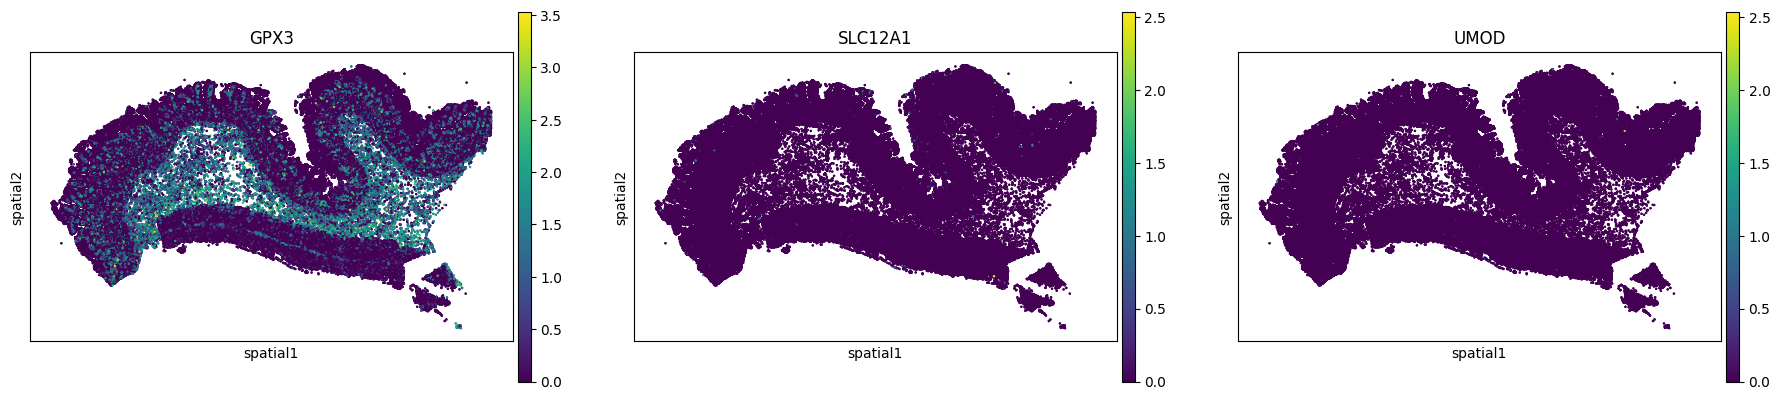

In [71]:
# plot selected highly variable genes
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    color=[
        "GPX3",
        "SLC12A1",
        "UMOD",
    ],
    shape=None,
    size=2,
    img=False,
)

## Gene Visualization

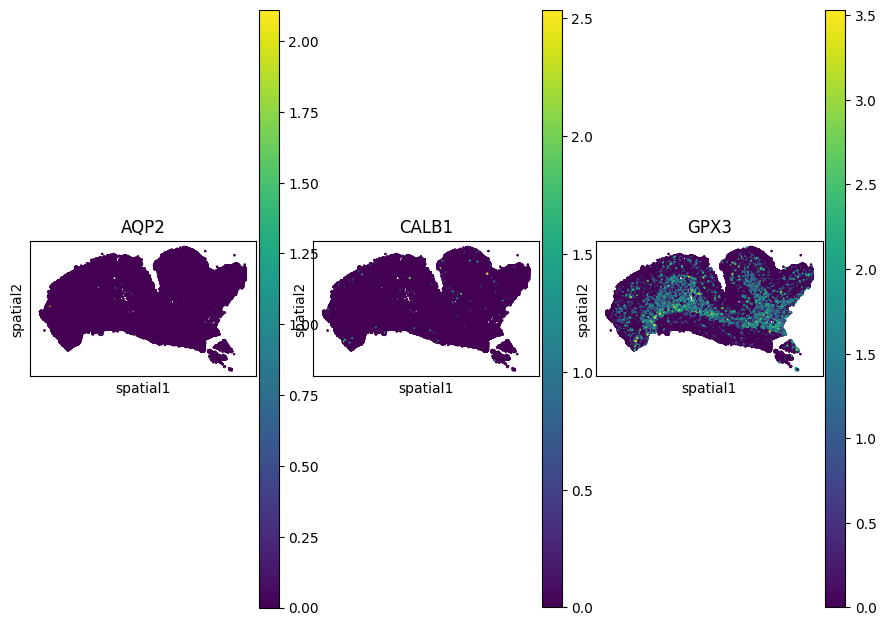

In [72]:
# visualize select genes
sq.pl.spatial_scatter(
   adata,
   library_id="spatial",
   color=[
       "AQP2",
       "CALB1",
       "GPX3",
    ],
    shape=None,
    size=2,
    img=False,
    figsize=(3, 8)
)

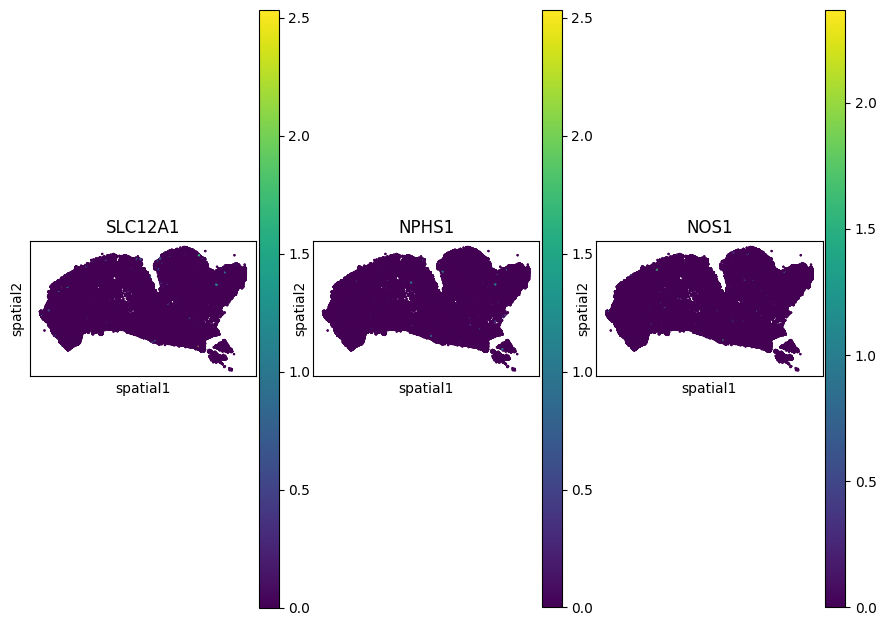

In [73]:
sq.pl.spatial_scatter(
   adata,
   library_id="spatial",
   color=[
       "SLC12A1",
       "NPHS1",
       "NOS1",
    ],
    shape=None,
    size=2,
    img=False,
    figsize=(3, 8)
)

## Import Desired Reference Object

In [74]:
# adata_5000_nodegen = ad.read_h5ad("/Users/stephreinert/Desktop/atlas_v2/downsampled_atlasv2_nodegen_5kcells.h5ad")
# adata_5000 = ad.read_h5ad("/Users/stephreinert/Desktop/atlas_v2/downsampled_atlasv2_5kcells.h5ad")
adata_50prop = ad.read_h5ad("/storage1/fs1/sanjayjain/Active/CosMx/adata_intestine.h5ad") 


## TACCO

In [75]:
tc.tl.annotate(adata, adata_50prop, annotation_key='celltype', result_key='v2.subclass.l1', assume_valid_counts=True,max_annotation = 1)

Starting preprocessing
Annotation profiles were not found in `reference.varm["celltype"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 43.13 seconds.
Starting annotation of data with shape (233395, 300) and a reference of shape (280109, 300) using the following wrapped method:
+- maximum annotation: max_annotation=1
   +- platform normalization: platform_iterations=0, gene_keys=celltype, normalize_to=adata
      +- multi center: multi_center=None multi_center_amplitudes=True
         +- bisection boost: bisections=4, bisection_divisor=3
            +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  2.81575043137587 22.391292436871236
bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 18.02 seconds.


AnnData object with n_obs × n_vars = 233395 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'hvg', 'umap', 'leiden', 'leiden_colors', 'spatial_neighbors', 'moranI'
    obsm: 'spatial', 'X_pca', 'X_umap', 'v2.subclass.l1'
    varm: 'PCs', 'v2.subclass.l1'
    layers: 'counts'
    obsp: 'distances', 'connectivities', 'spatial_

In [76]:
y = adata.obsm['v2.subclass.l1']
# Find the column where the value is 1.0
y['v2.subclass.l1'] = y.idxmax(axis=1)

In [77]:
adata.obs['v2.subclass.l1'] = y['v2.subclass.l1']

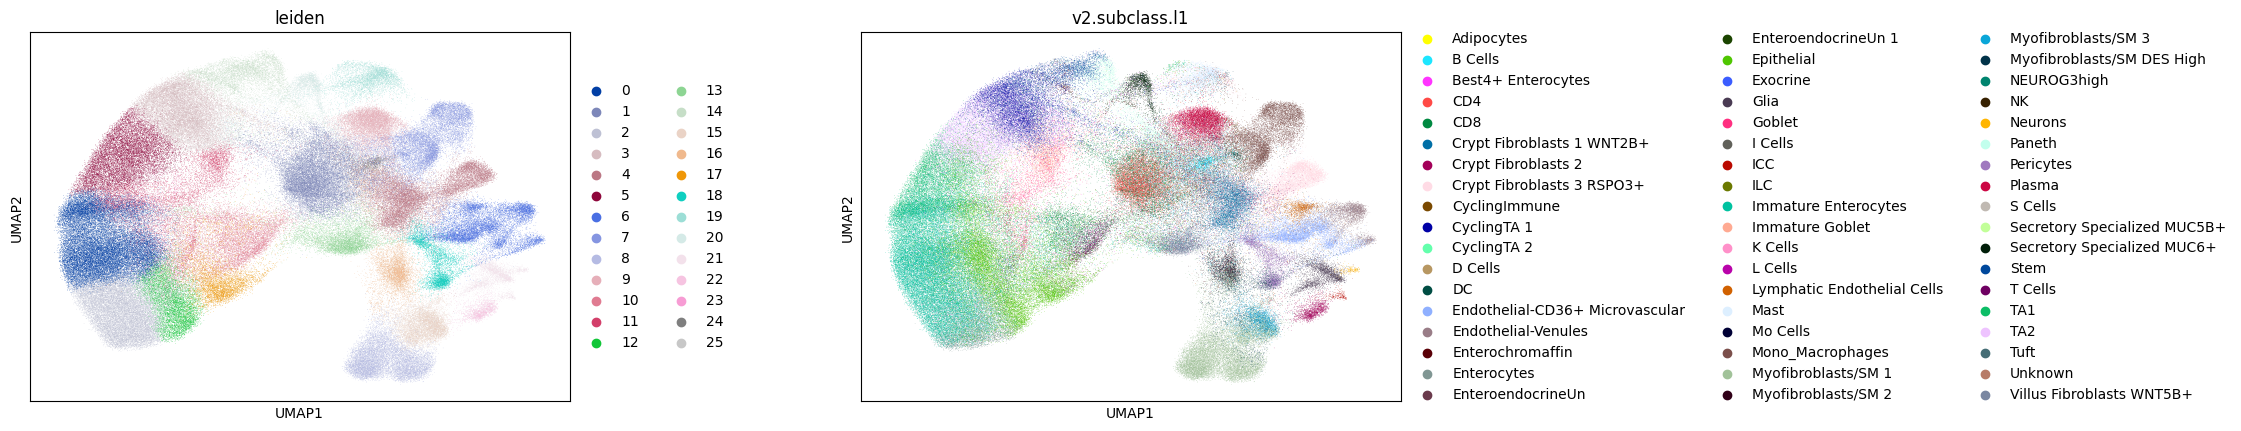

In [78]:
sc.pl.umap(
    adata,
    color=[
        "leiden",'v2.subclass.l1'
    ],
    wspace=0.4,
)

In [79]:
adata.obs['v2.subclass.l1'].value_counts()

v2.subclass.l1
Immature Enterocytes               34434
Epithelial                         22210
Myofibroblasts/SM 1                16318
TA2                                13276
Mono_Macrophages                   10916
TA1                                10391
Crypt Fibroblasts 3 RSPO3+          9315
CyclingTA 1                         9182
Enterocytes                         9095
Crypt Fibroblasts 1 WNT2B+          8111
CD8                                 7387
Endothelial-CD36+ Microvascular     7246
Plasma                              6975
CD4                                 5935
Stem                                4326
Immature Goblet                     4144
Myofibroblasts/SM DES High          3801
Glia                                3763
Paneth                              3677
Villus Fibroblasts WNT5B+           3657
Pericytes                           3645
Endothelial-Venules                 3450
Crypt Fibroblasts 2                 3087
Goblet                              2978
M

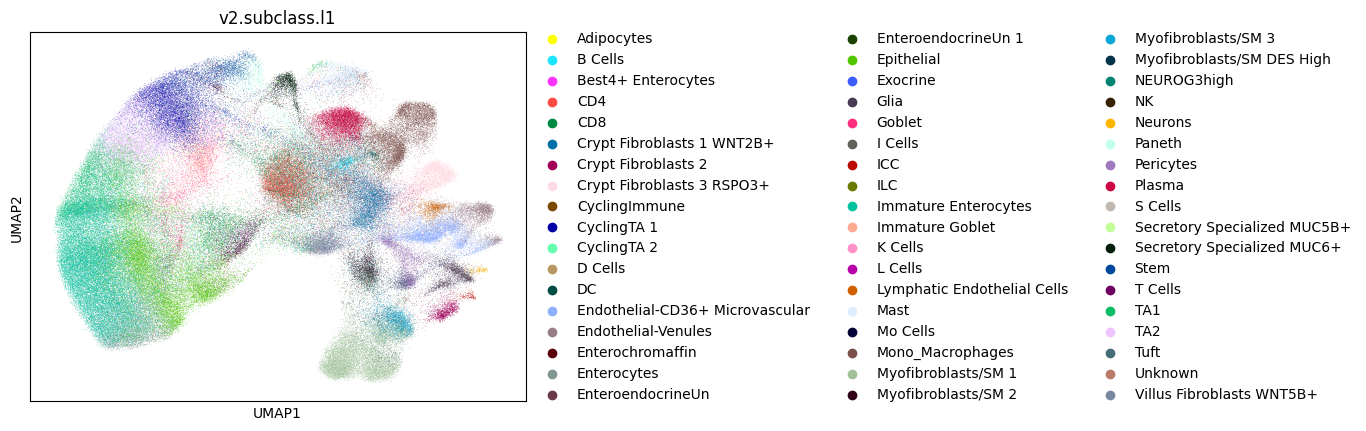

In [80]:
sc.pl.umap(adata, color=['v2.subclass.l1'], save="3781_Xen3_umap_l1.png")

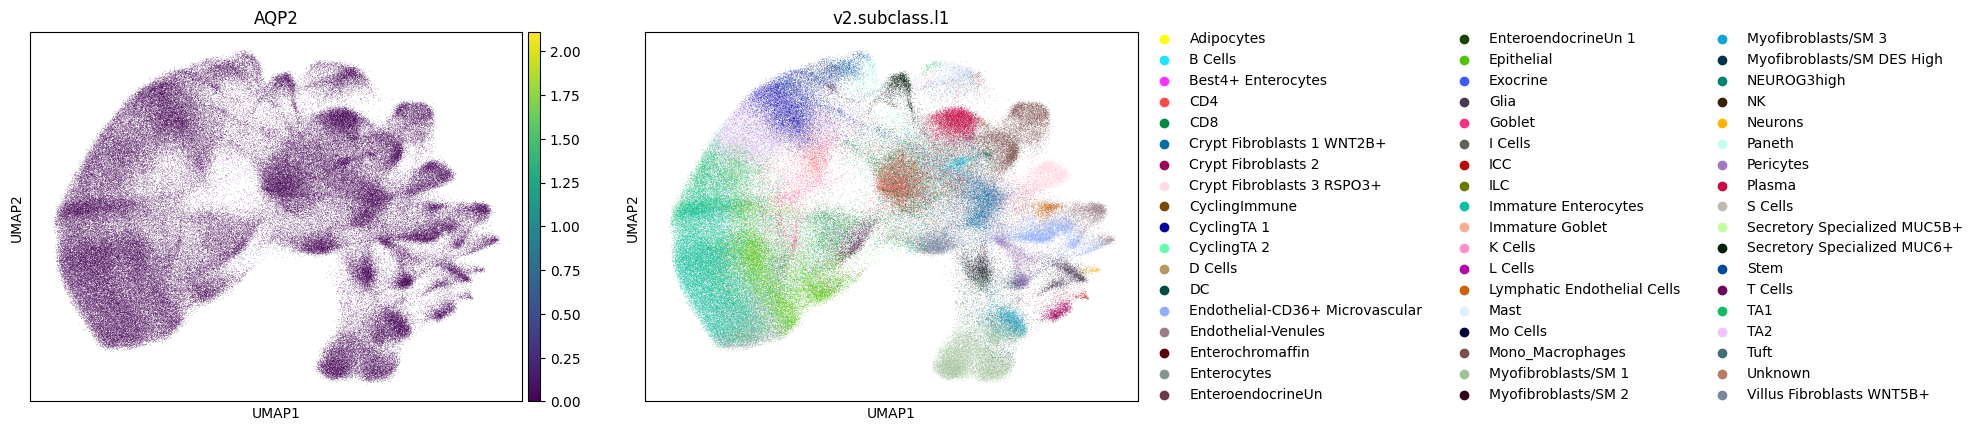

In [81]:
sc.pl.umap(adata, color=['AQP2','v2.subclass.l1'])

/usr/local/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/usr/local/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


FileNotFoundError: [Errno 2] No such file or directory: '/Users/stephreinert/Desktop/xenium/figures/3781_Xen3_spatial_scatter_plot.png'

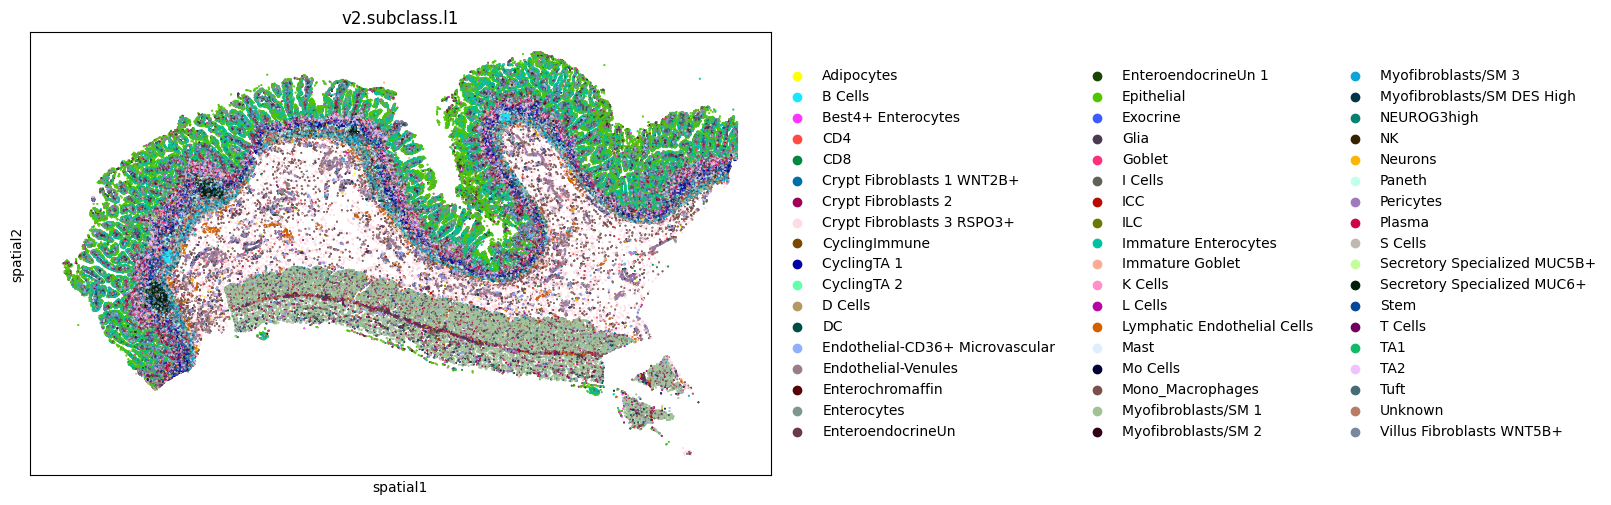

In [82]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    figsize = (16,14),
    color=[
        "v2.subclass.l1",
    ],
)

plt.savefig('/Users/stephreinert/Desktop/xenium/figures/3781_Xen3_spatial_scatter_plot.png', dpi=300, bbox_inches='tight')

In [83]:
adata.obs['v2.subclass.l1'].value_counts()

v2.subclass.l1
Immature Enterocytes               34434
Epithelial                         22210
Myofibroblasts/SM 1                16318
TA2                                13276
Mono_Macrophages                   10916
TA1                                10391
Crypt Fibroblasts 3 RSPO3+          9315
CyclingTA 1                         9182
Enterocytes                         9095
Crypt Fibroblasts 1 WNT2B+          8111
CD8                                 7387
Endothelial-CD36+ Microvascular     7246
Plasma                              6975
CD4                                 5935
Stem                                4326
Immature Goblet                     4144
Myofibroblasts/SM DES High          3801
Glia                                3763
Paneth                              3677
Villus Fibroblasts WNT5B+           3657
Pericytes                           3645
Endothelial-Venules                 3450
Crypt Fibroblasts 2                 3087
Goblet                              2978
M

In [84]:
# transcript count per cell type in v2.subclass.l1
transcript_counts_per_type = adata.obs.groupby('v2.subclass.l1', observed=True)['transcript_counts'].sum()
transcript_counts_per_type_df = transcript_counts_per_type.reset_index()
transcript_counts_per_type_df = transcript_counts_per_type_df.sort_values(by='transcript_counts', ascending=False)
print(transcript_counts_per_type_df)

# save to an Excel file
#transcript_counts_per_type_df.to_excel("transcript_counts_per_cell_type_l1.xlsx", index=False# number of cells per cell type in 'v2.subclass.l1'
cell_counts_per_type = adata.obs['v2.subclass.l1'].value_counts(sort=False)
cell_counts_per_type_df = cell_counts_per_type.reset_index()
cell_counts_per_type_df.columns = ['v2.subclass.l1', 'cell_count']

# proportion of cells per cell type in 'v2.subclass.l1'
cell_proportion_per_type = adata.obs['v2.subclass.l1'].value_counts(normalize=True, sort=False) * 100
cell_proportion_per_type_df = cell_proportion_per_type.reset_index()
cell_proportion_per_type_df.columns = ['v2.subclass.l1', 'proportion (%)']

# merge 
cell_counts_and_proportions_df = pd.merge(cell_counts_per_type_df, cell_proportion_per_type_df, on='v2.subclass.l1')

# sort and print
cell_counts_and_proportions_df = cell_counts_and_proportions_df.sort_values(by='cell_count', ascending=False)
print(cell_counts_and_proportions_df)

# save to excel
output_file_path = "/Users/stephreinert/Desktop/xenium/stats/3781_Xen3_subclass_counts_l1.xlsx"
cell_counts_and_proportions_df.to_excel(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

                     v2.subclass.l1  transcript_counts
26             Immature Enterocytes            4594400
19                       Epithelial            1501403
50                              TA2            1251605
49                              TA1            1142636
16                      Enterocytes            1138102
34              Myofibroblasts/SM 1            1054169
9                       CyclingTA 1             957865
33                 Mono_Macrophages             687505
7        Crypt Fibroblasts 3 RSPO3+             502075
13  Endothelial-CD36+ Microvascular             476067
47                             Stem             345129
5        Crypt Fibroblasts 1 WNT2B+             342497
4                               CD8             305864
27                  Immature Goblet             301479
42                        Pericytes             268665
46      Secretory Specialized MUC6+             230347
43                           Plasma             216954
21        

OSError: Cannot save file into a non-existent directory: '/Users/stephreinert/Desktop/xenium/stats'

## Add Metadata

In [85]:
adata.obs['PPID'] = 'B015H2'
adata.obs['Condition'] = 'Ref'
adata.obs['Tissue'] = 'Intestine'

In [86]:
adata

AnnData object with n_obs × n_vars = 233395 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'v2.subclass.l1', 'PPID', 'Condition', 'Tissue'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'hvg', 'umap', 'leiden', 'leiden_colors', 'spatial_neighbors', 'moranI', 'v2.subclass.l1_colors'
    obsm: 'spatial', 'X_pca', 'X_umap', 'v2.subclass.l1'
    varm: 'PCs', 'v2.subclass.l

## Save Object

In [87]:
# remove a specific key from the obsm attribute, e.g., 'v2.subclass.l1'
del adata.obsm['v2.subclass.l1']



# remove a specific key from the varm attribute, e.g., 'v2.subclass.l1'
del adata.varm['v2.subclass.l1']



In [89]:
adata.write_h5ad("/storage1/fs1/sanjayjain/Active/Xenium/Data/IntegratedST_Xenium_Data/B015_H2/B015_H2_obj.h5ad")